# Analysis of ENSO predictability

In [1]:
import re
import os
import glob
import doppyo
import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage.measurements import label

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Notebook specific -----
%matplotlib inline

In [2]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/papers/Risbey_Nature/figures'

# Notebook-specific functions

In [3]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [4]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [5]:
def cv_anomalize(fcst, clim_ts, time_dim = 'init_date'):
    """ Anomalize provided data in a "cross-validated" manner """
    
    fcst_dates = fcst[time_dim].values
    if not hasattr(fcst_dates, "__iter__"):
        fcst_dates = [fcst_dates]
    clim_dates = clim_ts[time_dim].values
    if not hasattr(clim_dates, "__iter__"):
        clim_dates = [clim_dates]
        
    clim = clim_ts.sel({time_dim : sorted(set(clim_dates) - set(fcst_dates))}) \
                  .groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [6]:
def Delsole_regression(da_predict,  da_train):
    """ 
        Build model over dates in da_predict using data in da_train
        Overlapping periods in da_predict and da_train are excluded from the training period
    """
    
    def _fit(da):
        return doppyo.utils.polyfit(da.sel(lead_time=0), da.sel(lead_time=range(1,12)), order=1, over_dims='init_date')
    
    def _predict(da, p):
        month = da.init_date.dt.month.values[0]
        return doppyo.utils.polyval(da, p.sel(month=month, drop=True), over_dims='init_date')

    if da_predict.shape == ():
        da_predict = da_predict.expand_dims('init_date')
    da_predict = doppyo.utils.prune(da_predict)

    train_dates = da_train['init_date'].values
    if not hasattr(train_dates, "__iter__"):
        train_dates = [train_dates]
    predict_dates = da_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]
        
    da_use = da_train.sel({'init_date' : sorted(set(train_dates) - set(predict_dates))})
    
    p = da_use.groupby('init_date.month').apply(_fit)
    
    if len(predict_dates) == 1:
        return _predict(da_predict, p=p).squeeze()
    else:
        return da_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [7]:
def where_elninos(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_elnino = da.rolling(init_date=3, center=True).mean() > 0.5
    where_elnino.values = label(1*where_elnino, structure=s)[0]
    
    return where_elnino

In [8]:
def where_laninas(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_lanina = da.rolling(init_date=3, center=True).mean() < -0.5
    where_lanina.values = label(1*where_lanina, structure=s)[0]
    
    return where_lanina

In [9]:
def where_condition_events(where_event, method):

    for event_id in range(1, where_event.max().values+1):
        specific_event = 1*(where_event == event_id)

        if method == 'decay':
            specific_event = -1 * (specific_event - 1)

        int_event = doppyo.utils.integrate(specific_event, over_dim='lead_time', 
                                            x=(1+0*specific_event.lead_time.astype(int)).cumsum('lead_time'), 
                                            method='rect', cumulative=True)
        int_cmpar = (1+0*specific_event.astype(int)).cumsum('lead_time')

        specific_event_conditioned = specific_event.where(int_event != int_cmpar, other=0)
        
        if method == 'decay':
            specific_event_conditioned = specific_event_conditioned.where(specific_event.sel(lead_time=0) == 0, other=0)
            
        if event_id == 1:
            event_conditioned = specific_event_conditioned
        else:
            event_conditioned = event_conditioned + specific_event_conditioned
            
    return event_conditioned

In [10]:
def plot_fcst(t, x, ax=None, cmap='jet', **kwargs):
    # Convert dates to numbers first ---- 
    try:
        inxval = matplotlib.dates.date2num(t.to_index().to_pydatetime())
        points = np.array([inxval, x.values]).T.reshape(-1,1,2)
    except:
        inxval = matplotlib.dates.date2num(t)
        points = np.array([inxval, x]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, **kwargs)
    lc.set_array(inxval)
    
    monthFmt = matplotlib.dates.DateFormatter("%Y")
    if ax is None:
        ax = plt.gca()
        
    ax.add_collection(lc)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.autoscale_view()
    ax.xaxis_date()

In [11]:
colors1 = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
colors2 = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
colors3 = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors4 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
colorsd = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
colors = colorsd

In [12]:
upper_color = (8 + np.array([0, 0, 1])) / 9
lower_color = (8 + np.array([1, 0, 0])) / 9

# A note about climatologies and bias corrections
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02.
The mutual span of these datasets is **1982-01 -> 2018-02**

In this notebook we compare and contrast a number of methods for computing anomalies and for bias correcting data. In all cases, **17 years of data are use to build climatologies**. The methods are abbreviated as follows:

**c0** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the period **1982-01 -> 1998-12** - see Saha et al. (2006), Kirtman (2003), Kirtman et al. (1997), Kirtman and Min (2009)... Observed anomalies are computed in the same way.

**c1** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology over the same period using cross-validation - see Kirtman and Min (2009), Kirtman *et al.* (2014)... Similarly, observed anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the same period using cross-validation

**c2** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology over the period **1982-01 -> 1998-12**. Similarly, observed anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the period **1982-01 -> 1998-12**. A similar approach is taken by Wang et al. (2010), Goddard et al. (2013).

**c3** : as in Delsole and Tippet, the (lead-time-dependent) mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive. This error is then subtracted from the **c0** anomalies. This approach is subtly different from **c2** - if instead, the mean error were computed as the difference between the lead-time-dependent model climatology and the observed climatology over the period 1982-1998, then **c3** -> **c2**. Observed anomalies are the same as for **c2**. A similar approach is taken by Barnston et al. (2003)

**Note**, in actuality model anomalies are computed over the full model period, but they should only be examined for **1999-01 -> 2015-12**

For comparison, we also compute:

**c1full** : model anomalies over the period **1982-01 -> 2015-12** are computed relative to the ensemble mean, lead=0 model climatology over the same period using cross-validation - see Kirtman and Min (2009), Kirtman *et al.* (2014)... Similarly, observed anomalies over the period **1982-01 -> 2015-12** are computed relative to the observed climatology over the same period using cross-validation

**c1ncv** : model anomalies over the period **1982-01 -> 2015-12** are computed relative to the ensemble mean, lead=0 model climatology over the same period **without cross-validation**. Similarly, observed anomalies over the period **1982-01 -> 2015-12** are computed relative to the observed climatology over the same period **without cross-validation**

# Load the data

In [13]:
compute_data = True # If True, recomputes quantities from raw data and saves to dataloc, otherwise loads from dataloc
dataloc = '/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/'

### Raw NOAA OISST data (downloaded from http://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices)

In [14]:
time = pd.date_range(start='1982-01',end='2019-03',freq='MS')
data = np.array([25.87,26.38,26.98,27.68,27.79,27.46,26.44,26.15,26.52,27.11,27.62,28.39,28.92,28.92,29.1,29.12,28.97,28.15,26.62,25.87,25.24,24.61,24.17,24.44,24.82,26.22,27.12,27.34,26.46,25.38,24.96,24.5,24.35,23.95,24.03,23.7,24.51,25.19,26.11,26.52,26.12,25.6,24.74,24.4,24.15,24.15,24.28,24.29,24.73,25.81,26.84,27.17,26.68,26.3,25.7,25.02,25.25,25.62,25.92,25.86,26.69,27.42,28.2,28.49,28.22,27.71,27.07,26.52,26.57,26.2,26.13,26.2,26.12,26.55,27.14,26.73,25.22,24.46,23.71,23.37,23.61,23.17,23.03,23.07,24.15,25.61,26.02,26.67,26.37,26.08,25.28,24.56,24.45,24.49,24.56,24.71,25.34,26.37,27.03,27.67,27.35,26.45,25.45,25.06,24.85,24.9,24.82,25.08,25.65,26.27,26.99,27.32,27.58,27.34,26.57,25.47,25.05,25.6,25.98,26.52,27,27.67,28.33,28.72,28.43,26.66,25.53,24.7,24.52,24.62,24.79,25.01,25.56,26.61,27.54,28.45,28.16,27.11,25.77,24.93,24.97,25.21,25.17,25.32,25.71,26.07,26.89,27.06,26.97,26.5,25.19,24.71,24.81,25.53,25.87,26.07,26.34,26.87,27.08,27.1,26.4,26.2,25.42,24.33,24.02,24.01,24.03,24.19,24.96,25.72,26.71,26.72,26.33,25.89,25.35,24.6,24.37,24.37,24.38,24.2,24.7,25.75,26.98,27.59,28.06,28.14,28.01,27.84,27.84,28.17,28.55,28.76,28.94,28.93,29.14,29.09,28.17,26,25.24,24.63,24.19,24.06,24.11,23.86,24.41,25.57,26.67,26.66,26.44,25.59,24.85,24.02,23.72,23.75,23.46,23.54,23.88,25.31,26.61,27.46,26.8,25.84,25.13,24.47,24.35,24.41,24.17,24.43,24.99,26.06,27.23,27.52,26.89,26.35,25.43,24.72,24.27,24.45,24.35,24.6,25.09,26.21,27.22,27.56,27.24,27.06,26.03,25.47,25.54,25.85,26.37,26.48,26.38,26.7,27.28,27.15,26.14,25.83,25.75,25.04,24.97,25.33,25.4,25.56,25.92,26.46,27.16,27.37,26.72,26.27,25.41,25.05,25.17,25.32,25.46,25.77,25.89,26.2,27.01,27.77,27.48,26.81,25.93,25.19,24.57,24.69,24.28,24.28,25,26.08,26.54,27.25,27.04,26.44,25.8,25.45,25.74,25.96,26.07,26.36,26.5,26.45,26.79,27.13,26.35,25.83,24.79,23.86,23.52,23.36,23.17,23.59,24.13,25.05,26.56,27.18,27.08,26.53,26.12,25.63,25.09,24.79,24.75,24.6,25.03,25.85,26.44,27.39,27.4,27.12,26.56,25.94,25.66,25.73,26.23,26.67,26.63,27.12,27.73,28.05,26.97,25.75,24.53,23.87,23.59,23.25,23.4,23.5,24.31,25.55,26.39,27.18,26.94,26.54,25.61,24.58,24.22,23.97,23.89,24.2,24.9,26.19,26.92,27.58,27.23,27.09,26.54,25.72,25.28,24.93,25.11,24.91,25.06,25.9,27.21,27.35,26.39,25.8,24.97,24.44,24.72,24.7,24.81,25.1,25.26,25.56,26.9,27.73,27.69,27.32,26.27,25.51,25.31,25.58,25.88,25.94,25.99,26.55,27.29,28.17,28.28,28.1,27.79,27.33,27.48,27.58,27.91,27.99,28.21,28.36,28.7,28.34,27.11,26.31,25.14,24.53,24.67,24.47,24.58,24.78,25.61,27,27.7,28.09,27.6,26.73,25.85,24.82,24.17,24.28,23.92,24.05,24.48,25.36,26.37,27.12,26.94,26.72,26.05,25.14,25.2,25.78,26.02,26.12,26.17,26.91,27.88])

oisst_nino3_full_ts = xr.DataArray(data, coords=[('time', time)])
oisst_nino3_full = doppyo.utils.stack_by_init_date(oisst_nino3_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('full')

##### c0 anomalies

In [15]:
if compute_data:
    clim_period = slice('1982','1998')
    oisst_nino3_c0_ts = (oisst_nino3_full_ts.groupby('time.month') - oisst_nino3_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    oisst_nino3_c0 = doppyo.utils.stack_by_init_date(oisst_nino3_c0_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c0')
    
    oisst_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c0.nc')
else:
    oisst_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c0.nc')['c0']

##### c1 anomalies

In [16]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = oisst_nino3_full_ts.sel(time=clim_period)
    oisst_nino3_c1_ts = oisst_nino3_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    oisst_nino3_c1 = doppyo.utils.stack_by_init_date(oisst_nino3_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1').drop('month')
    
    oisst_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c1.nc')
else:
    oisst_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c1.nc')['c1']

##### c2 anomalies

In [17]:
if compute_data:
    oisst_nino3_c2_ts = oisst_nino3_c0_ts
    oisst_nino3_c2 = oisst_nino3_c0.rename('c2')
    
    oisst_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c2.nc')
else:
    oisst_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c2.nc')['c2']

##### c3 anomalies

In [18]:
if compute_data:
    oisst_nino3_c3_ts = oisst_nino3_c0_ts
    oisst_nino3_c3 = oisst_nino3_c0.rename('c3')
    
    oisst_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c3.nc')
else:
    oisst_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c3.nc')['c3']

##### c1 full anomalies

In [19]:
if compute_data:
    clim_period = slice('1982','2015')
    clim_use = oisst_nino3_full_ts.sel(time=clim_period)
    oisst_nino3_c1full_ts = oisst_nino3_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    oisst_nino3_c1full = doppyo.utils.stack_by_init_date(oisst_nino3_c1full_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1full').drop('month')
    
    oisst_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c1full.nc')
else:
    oisst_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [20]:
if compute_data:
    clim_period = slice('1999','2015')
    oisst_nino3_c1ncv_ts = (oisst_nino3_full_ts.groupby('time.month') - oisst_nino3_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    oisst_nino3_c1ncv = doppyo.utils.stack_by_init_date(oisst_nino3_c1ncv_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c1ncv')
    
    oisst_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino3_c1ncv.nc')
else:
    oisst_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [21]:
oisst_nino3 = oisst_nino3_full.to_dataset()
oisst_nino3['c0'] = oisst_nino3_c0
oisst_nino3['c1'] = oisst_nino3_c1
oisst_nino3['c2'] = oisst_nino3_c2
oisst_nino3['c3'] = oisst_nino3_c3
oisst_nino3['c1full'] = oisst_nino3_c1full
oisst_nino3['c1ncv'] = oisst_nino3_c1ncv

### Raw Hadley ISST data

In [22]:
if compute_data:
    had_sst_full_ts = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.had_sst_raw_ts.nc')['sst'].rename('hadsst')
    had_nino3_full_ts = doppyo.diagnostic.nino3(had_sst_full_ts).rename('full_ts')
    had_nino3_full = doppyo.utils.stack_by_init_date(had_nino3_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('full')
    
    had_nino3_full_ts.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_full_ts.nc')
    had_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_full.nc')
else:
    had_nino3_full_ts = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_full_ts.nc')['full_ts']
    had_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_full.nc')['full']

##### c0 anomalies

In [23]:
if compute_data:
    clim_period = slice('1982','1998')
    had_nino3_c0_ts = (had_nino3_full_ts.groupby('time.month') - had_nino3_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    had_nino3_c0 = doppyo.utils.stack_by_init_date(had_nino3_c0_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c0')
    
    had_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c0.nc')
else:
    had_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c0.nc')['c0']

##### c1 anomalies

In [24]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = had_nino3_full_ts.sel(time=clim_period)
    had_nino3_c1_ts = had_nino3_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    had_nino3_c1 = doppyo.utils.stack_by_init_date(had_nino3_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1').drop('month')
    
    had_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c1.nc')
else:
    had_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c1.nc')['c1']

##### c2 anomalies

In [25]:
if compute_data:
    had_nino3_c2_ts = had_nino3_c0_ts
    had_nino3_c2 = had_nino3_c0.rename('c2')
    
    had_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c2.nc')
else:
    had_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c2.nc')['c2']

##### c3 anomalies

In [26]:
if compute_data:
    had_nino3_c3_ts = had_nino3_c0_ts
    had_nino3_c3 = had_nino3_c0.rename('c3')
    
    had_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c3.nc')
else:
    had_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c3.nc')['c3']

##### c1 full anomalies

In [27]:
if compute_data:
    clim_period = slice('1982','2015')
    clim_use = had_nino3_full_ts.sel(time=clim_period)
    had_nino3_c1full_ts = had_nino3_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    had_nino3_c1full = doppyo.utils.stack_by_init_date(had_nino3_c1full_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1full').drop('month')
    
    had_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c1full.nc')
else:
    had_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [28]:
if compute_data:
    clim_period = slice('1999','2015')
    had_nino3_c1ncv_ts = (had_nino3_full_ts.groupby('time.month') - had_nino3_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    had_nino3_c1ncv = doppyo.utils.stack_by_init_date(had_nino3_c1ncv_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c1ncv')
    
    had_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.had_nino3_c1ncv.nc')
else:
    had_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [29]:
had_nino3 = had_nino3_full.to_dataset()
had_nino3['c0'] = had_nino3_c0
had_nino3['c1'] = had_nino3_c1
had_nino3['c2'] = had_nino3_c2
had_nino3['c3'] = had_nino3_c3
had_nino3['c1full'] = had_nino3_c1full
had_nino3['c1ncv'] = had_nino3_c1ncv

# Choose which obs to use

In [30]:
obs_2_use = oisst_nino3 # had_nino3

### Raw COLA-RSMAS-CCSM4 data

In [31]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/COLA-RSMAS-CCSM4/monthly/sst_mon_COLA-RSMAS-CCSM4_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    cola_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cola_sst_raw.init_date.units.split(' ')[2])
    cola_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cola_sst_raw.init_date.values])

    cola_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cola_sst_raw['lead_time']]
    cola_sst_raw.lead_time.attrs['units'] = 'MS'

    cola_sst_raw['ensemble'] = [int(ensemble) for ensemble in cola_sst_raw['ensemble']]

##### Compute nino3

In [32]:
if compute_data:
    cola_nino3_full = doppyo.diagnostic.nino3(cola_sst_raw).rename('full')
    
    cola_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_full.nc')
else:
    cola_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_full.nc')['full']

##### c0 anomalies

In [33]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cola_nino3_c0 = cola_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cola_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c0.nc')
else:
    cola_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c0.nc')['c0']

##### c1 anomalies

In [34]:
if compute_data:
    clim_period = slice('1999','2015')
    cola_nino3_full_use = cola_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino3_c1 = cola_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino3_full_use).rename('c1')
    
    cola_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c1.nc')
else:
    cola_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c1.nc')['c1']

##### c2 anomalies

In [35]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cola_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cola_nino3_c2 = (cola_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    cola_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c2.nc')
else:
    cola_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c2.nc')['c2']

##### c3 anomalies

In [36]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cola_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cola_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cola_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cola_nino3_c3 = (cola_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cola_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c3.nc')
else:
    cola_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c3.nc')['c3']

##### c1 full anomalies

In [37]:
if compute_data:
    clim_period = slice('1982','2015')
    cola_nino3_full_use = cola_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino3_c1full = cola_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino3_full_use).rename('c1full')
    
    cola_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c1full.nc')
else:
    cola_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [38]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cola_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cola_nino3_c1ncv = (cola_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cola_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cola_nino3_c1ncv.nc')
else:
    cola_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [39]:
cola_nino3 = cola_nino3_full.to_dataset()
cola_nino3['c0'] = cola_nino3_c0
cola_nino3['c1'] = cola_nino3_c1
cola_nino3['c2'] = cola_nino3_c2
cola_nino3['c3'] = cola_nino3_c3
cola_nino3['c1full'] = cola_nino3_c1full
cola_nino3['c1ncv'] = cola_nino3_c1ncv

### Raw GFDL-CM2p1-aer04 data

In [40]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p1-aer04/monthly/sst_mon_GFDL-CM2p1-aer04_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    aer04_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute() - 273.15

    basedate = np.datetime64(aer04_sst_raw.init_date.units.split(' ')[2])
    aer04_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in aer04_sst_raw.init_date.values])

    aer04_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in aer04_sst_raw['lead_time']]
    aer04_sst_raw.lead_time.attrs['units'] = 'MS'

    aer04_sst_raw['ensemble'] = [int(ensemble) for ensemble in aer04_sst_raw['ensemble']]

##### Compute nino3

In [41]:
if compute_data:
    aer04_nino3_full = doppyo.diagnostic.nino3(aer04_sst_raw).rename('full')
    
    aer04_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_full.nc')
else:
    aer04_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_full.nc')['full']

##### c0 anomalies

In [42]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    aer04_nino3_c0 = aer04_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    aer04_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c0.nc')
else:
    aer04_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c0.nc')['c0']

##### c1 anomalies

In [45]:
if compute_data:
    clim_period = slice('1999','2015')
    aer04_nino3_full_use = aer04_nino3_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino3_c1 = aer04_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino3_full_use).rename('c1')
    
    aer04_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c1.nc')
else:
    aer04_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c1.nc')['c1']

##### c2 anomalies

In [46]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = aer04_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    aer04_nino3_c2 = (aer04_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    aer04_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c2.nc')
else:
    aer04_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c2.nc')['c2']

##### c3 anomalies

In [47]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = aer04_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = aer04_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (aer04_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    aer04_nino3_c3 = (aer04_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    aer04_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c3.nc')
else:
    aer04_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c3.nc')['c3']

##### c1 full anomalies

In [48]:
if compute_data:
    clim_period = slice('1982','2015')
    aer04_nino3_full_use = aer04_nino3_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino3_c1full = aer04_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino3_full_use).rename('c1full')
    
    aer04_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c1full.nc')
else:
    aer04_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [49]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = aer04_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    aer04_nino3_c1ncv = (aer04_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    aer04_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino3_c1ncv.nc')
else:
    aer04_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [50]:
aer04_nino3 = aer04_nino3_full.to_dataset()
aer04_nino3['c0'] = aer04_nino3_c0
aer04_nino3['c1'] = aer04_nino3_c1
aer04_nino3['c2'] = aer04_nino3_c2
aer04_nino3['c3'] = aer04_nino3_c3
aer04_nino3['c1full'] = aer04_nino3_c1full
aer04_nino3['c1ncv'] = aer04_nino3_c1ncv

### Raw GFDL-CM2p5-FLOR-A06 data

In [51]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-A06/monthly/sst_mon_GFDL-CM2p5-FLOR-A06_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florA_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florA_sst_raw.init_date.units.split(' ')[2])
    florA_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florA_sst_raw.init_date.values])

    florA_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florA_sst_raw['lead_time']]
    florA_sst_raw.lead_time.attrs['units'] = 'MS'

    florA_sst_raw['ensemble'] = [int(ensemble) for ensemble in florA_sst_raw['ensemble']]

##### Compute nino3

In [52]:
if compute_data:
    florA_nino3_full = doppyo.diagnostic.nino3(florA_sst_raw).rename('full')
    
    florA_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_full.nc')
else:
    florA_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_full.nc')['full']

##### c0 anomalies

In [53]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    florA_nino3_c0 = florA_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    florA_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c0.nc')
else:
    florA_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c0.nc')['c0']

##### c1 anomalies

In [54]:
if compute_data:
    clim_period = slice('1999','2015')
    florA_nino3_full_use = florA_nino3_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino3_c1 = florA_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino3_full_use).rename('c1')
    
    florA_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c1.nc')
else:
    florA_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c1.nc')['c1']

##### c2 anomalies

In [55]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = florA_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florA_nino3_c2 = (florA_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    florA_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c2.nc')
else:
    florA_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c2.nc')['c2']

##### c3 anomalies

In [56]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = florA_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = florA_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (florA_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    florA_nino3_c3 = (florA_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    florA_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c3.nc')
else:
    florA_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c3.nc')['c3']

##### c1 full anomalies

In [57]:
if compute_data:
    clim_period = slice('1982','2015')
    florA_nino3_full_use = florA_nino3_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino3_c1full = florA_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino3_full_use).rename('c1full')
    
    florA_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c1full.nc')
else:
    florA_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [58]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = florA_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florA_nino3_c1ncv = (florA_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    florA_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.florA_nino3_c1ncv.nc')
else:
    florA_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [59]:
florA_nino3 = florA_nino3_full.to_dataset()
florA_nino3['c0'] = florA_nino3_c0
florA_nino3['c1'] = florA_nino3_c1
florA_nino3['c2'] = florA_nino3_c2
florA_nino3['c3'] = florA_nino3_c3
florA_nino3['c1full'] = florA_nino3_c1full
florA_nino3['c1ncv'] = florA_nino3_c1ncv

### Raw GFDL-CM2p5-FLOR-B01 data

In [60]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-B01/monthly/sst_mon_GFDL-CM2p5-FLOR-B01_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florB_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florB_sst_raw.init_date.units.split(' ')[2])
    florB_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florB_sst_raw.init_date.values])

    florB_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florB_sst_raw['lead_time']]
    florB_sst_raw.lead_time.attrs['units'] = 'MS'

    florB_sst_raw['ensemble'] = [int(ensemble) for ensemble in florB_sst_raw['ensemble']]

##### Compute nino3

In [61]:
if compute_data:
    florB_nino3_full = doppyo.diagnostic.nino3(florB_sst_raw).rename('full')

    florB_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_full.nc')
else:
    florB_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_full.nc')['full']

##### c0 anomalies

In [62]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    florB_nino3_c0 = florB_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    florB_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c0.nc')
else:
    florB_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c0.nc')['c0']

##### c1 anomalies

In [63]:
if compute_data:
    clim_period = slice('1999','2015')
    florB_nino3_full_use = florB_nino3_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino3_c1 = florB_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino3_full_use).rename('c1')
    
    florB_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c1.nc')
else:
    florB_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c1.nc')['c1']

##### c2 anomalies

In [64]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = florB_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florB_nino3_c2 = (florB_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    florB_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c2.nc')
else:
    florB_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c2.nc')['c2']

##### c3 anomalies

In [65]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = florB_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = florB_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (florB_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    florB_nino3_c3 = (florB_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    florB_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c3.nc')
else:
    florB_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c3.nc')['c3']

##### c1 full anomalies

In [66]:
if compute_data:
    clim_period = slice('1982','2015')
    florB_nino3_full_use = florB_nino3_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino3_c1full = florB_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino3_full_use).rename('c1full')
    
    florB_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c1full.nc')
else:
    florB_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [67]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = florB_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florB_nino3_c1ncv = (florB_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    florB_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.florB_nino3_c1ncv.nc')
else:
    florB_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [68]:
florB_nino3 = florB_nino3_full.to_dataset()
florB_nino3['c0'] = florB_nino3_c0
florB_nino3['c1'] = florB_nino3_c1
florB_nino3['c2'] = florB_nino3_c2
florB_nino3['c3'] = florB_nino3_c3
florB_nino3['c1full'] = florB_nino3_c1full
florB_nino3['c1ncv'] = florB_nino3_c1ncv

### Raw CMC CanCM3 data

In [69]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM3/monthly/'
    hcstfiles = 'sst_mon_CanCM3_198101*.nc'
    fcstfiles = 'sst_mon_CanCM3_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm3_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm3_sst_raw.init_date.units.split(' ')[2])
    cm3_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm3_sst_raw.init_date.values])

    cm3_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm3_sst_raw['lead_time']]
    cm3_sst_raw.lead_time.attrs['units'] = 'MS'

    cm3_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm3_sst_raw['ensemble']]

##### Compute nino3

In [70]:
if compute_data:
    cm3_nino3_full = doppyo.diagnostic.nino3(cm3_sst_raw).rename('full')

    cm3_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_full.nc')
else:
    cm3_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_full.nc')['full']

##### c0 anomalies

In [71]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cm3_nino3_c0 = cm3_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cm3_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c0.nc')
else:
    cm3_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c0.nc')['c0']

##### c1 anomalies

In [72]:
if compute_data:
    clim_period = slice('1999','2015')
    cm3_nino3_full_use = cm3_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino3_c1 = cm3_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino3_full_use).rename('c1')
    
    cm3_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c1.nc')
else:
    cm3_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c1.nc')['c1']

##### c2 anomalies

In [73]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cm3_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm3_nino3_c2 = (cm3_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    cm3_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c2.nc')
else:
    cm3_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c2.nc')['c2']

##### c3 anomalies

In [74]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cm3_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cm3_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cm3_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cm3_nino3_c3 = (cm3_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cm3_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c3.nc')
else:
    cm3_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c3.nc')['c3']

##### c1 full anomalies

In [75]:
if compute_data:
    clim_period = slice('1982','2015')
    cm3_nino3_full_use = cm3_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino3_c1full = cm3_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino3_full_use).rename('c1full')
    
    cm3_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c1full.nc')
else:
    cm3_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [76]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cm3_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm3_nino3_c1ncv = (cm3_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cm3_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino3_c1ncv.nc')
else:
    cm3_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [77]:
cm3_nino3 = cm3_nino3_full.to_dataset()
cm3_nino3['c0'] = cm3_nino3_c0
cm3_nino3['c1'] = cm3_nino3_c1
cm3_nino3['c2'] = cm3_nino3_c2
cm3_nino3['c3'] = cm3_nino3_c3
cm3_nino3['c1full'] = cm3_nino3_c1full
cm3_nino3['c1ncv'] = cm3_nino3_c1ncv

### Raw CMC CanCM4 data

In [78]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM4/monthly/'
    hcstfiles = 'sst_mon_CanCM4_198101*.nc'
    fcstfiles = 'sst_mon_CanCM4_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm4_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm4_sst_raw.init_date.units.split(' ')[2])
    cm4_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm4_sst_raw.init_date.values])

    cm4_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm4_sst_raw['lead_time']]
    cm4_sst_raw.lead_time.attrs['units'] = 'MS'

    cm4_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm4_sst_raw['ensemble']]

##### Compute nino3

In [79]:
if compute_data:
    cm4_nino3_full = doppyo.diagnostic.nino3(cm4_sst_raw).rename('full')

    cm4_nino3_full.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_full.nc')
else:
    cm4_nino3_full = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_full.nc')['full']

##### c0 anomalies

In [80]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cm4_nino3_c0 = cm4_nino3_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cm4_nino3_c0.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c0.nc')
else:
    cm4_nino3_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c0.nc')['c0']

##### c1 anomalies

In [81]:
if compute_data:
    clim_period = slice('1999','2015')
    cm4_nino3_full_use = cm4_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino3_c1 = cm4_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino3_full_use).rename('c1')
    
    cm4_nino3_c1.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c1.nc')
else:
    cm4_nino3_c1 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c1.nc')['c1']

##### c2 anomalies

In [82]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cm4_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm4_nino3_c2 = (cm4_nino3_full.groupby('init_date.month') - clim).rename('c2')
    
    cm4_nino3_c2.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c2.nc')
else:
    cm4_nino3_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c2.nc')['c2']

##### c3 anomalies

In [83]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cm4_nino3_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cm4_nino3_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cm4_nino3_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cm4_nino3_c3 = (cm4_nino3_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cm4_nino3_c3.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c3.nc')
else:
    cm4_nino3_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c3.nc')['c3']

##### c1 full anomalies

In [84]:
if compute_data:
    clim_period = slice('1982','2015')
    cm4_nino3_full_use = cm4_nino3_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino3_c1full = cm4_nino3_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino3_full_use).rename('c1full')
    
    cm4_nino3_c1full.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c1full.nc')
else:
    cm4_nino3_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c1full.nc')['c1full']

##### c1 ncv anomalies

In [85]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cm4_nino3_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm4_nino3_c1ncv = (cm4_nino3_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cm4_nino3_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino3_c1ncv.nc')
else:
    cm4_nino3_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino3_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [86]:
cm4_nino3 = cm4_nino3_full.to_dataset()
cm4_nino3['c0'] = cm4_nino3_c0
cm4_nino3['c1'] = cm4_nino3_c1
cm4_nino3['c2'] = cm4_nino3_c2
cm4_nino3['c3'] = cm4_nino3_c3
cm4_nino3['c1full'] = cm4_nino3_c1full
cm4_nino3['c1ncv'] = cm4_nino3_c1ncv

# Make sure that we are using the same number of members for each model

In [87]:
n_members = 10
cola_nino3 = cola_nino3.sel(ensemble = np.arange(1,n_members+1))
aer04_nino3 = aer04_nino3.sel(ensemble = np.arange(1,n_members+1))
florA_nino3 = florA_nino3.sel(ensemble = np.arange(1,n_members+1))
florB_nino3 = florB_nino3.sel(ensemble = np.arange(1,n_members+1))
cm3_nino3 = cm3_nino3.sel(ensemble = np.arange(1,n_members+1))
cm4_nino3 = cm4_nino3.sel(ensemble = np.arange(1,n_members+1))

# Multi-model mean

In [88]:
mmm_nino3 = xr.concat([cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3], dim='ensemble').mean('ensemble')

# Ordinary linear regression model
For each of c0, c1, c2 and c3, the linear regression model is compute in a way consistent with how the observed anomalies are computed:

**c0** : the regression model is trained on observed c0 anomalies over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1** : the regression model is trained on observed c1 anomalies over the period **1999-01 -> 2015-12** using a cross-validation approach and then applied over the same period

**c2** : the regression model is trained on observed c2 anomalies (same as c1) over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1full** : the regression model is trained on observed c1 anomalies over the period **1982-01 -> 2015-12** using a cross-validation approach and then applied over the same period

##### c0 regression model

In [89]:
train_period = slice('1982','1998')
predict_period = slice('1999','2015')
regr_nino3_c0 = Delsole_regression(obs_2_use['c0'].sel(init_date=predict_period, lead_time=0),
                                    obs_2_use['c0'].sel(init_date=train_period)).rename('c0')

##### c1 regression model

In [90]:
train_period = slice('1999','2015')
predict_period = slice('1999','2015')
regr_nino3_c1 = obs_2_use['c1'].sel(init_date=predict_period).sel(lead_time=0,drop=True).groupby('init_date') \
                                 .apply(Delsole_regression, da_train=obs_2_use['c1'].sel(init_date=train_period)).rename('c1')

##### c2 regression model

In [91]:
regr_nino3_c2 = regr_nino3_c0.rename('c2')

##### c3 regression model

In [92]:
regr_nino3_c3 = regr_nino3_c0.rename('c3')

##### c1 full regression model

In [93]:
train_period = slice('1982','2015')
predict_period = slice('1982','2015')
regr_nino3_c1full = obs_2_use['c1full'].sel(init_date=predict_period).sel(lead_time=0,drop=True).groupby('init_date') \
                                 .apply(Delsole_regression, da_train=obs_2_use['c1full'].sel(init_date=train_period)).rename('c1full')

##### Combine into dataset

In [94]:
regr_nino3 = regr_nino3_c0.to_dataset()
regr_nino3['c1'] = regr_nino3_c1
regr_nino3['c2'] = regr_nino3_c2
regr_nino3['c3'] = regr_nino3_c3
regr_nino3['c1full'] = regr_nino3_c1full

# Choose which of **c2** or **c3** to use as the "good practice" case

In [95]:
c_gp = 'c2'

# Get ENSO events

In [96]:
where_elnino = obs_2_use.apply(where_elninos).drop('full')
where_lanina = obs_2_use.apply(where_laninas).drop('full')

where_elnino_cola = cola_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cola = cola_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_aer04 = aer04_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_aer04 = aer04_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_florA = florA_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_florA = florA_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_florB = florB_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_florB = florB_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_cm3 = cm3_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cm3 = cm3_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_cm4 = cm4_nino3.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cm4 = cm4_nino3.mean('ensemble').apply(where_laninas).drop('full')

where_elnino_mmm = mmm_nino3.apply(where_elninos).drop('full')
where_lanina_mmm = mmm_nino3.apply(where_laninas).drop('full')

where_elnino_regr = regr_nino3.apply(where_elninos)
where_lanina_regr = regr_nino3.apply(where_laninas)

# Get El Nino and La Nina **onset** periods
Here we assess, for each of El Nino and La Nina, forecasts which end in an event, but are **not** started in the same event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [97]:
where_elnino_onset = where_elnino.apply(where_condition_events, method='onset')
where_lanina_onset = where_lanina.apply(where_condition_events, method='onset')

# Get El Nino and La Nina **decay** periods
Here we assess, for each of El Nino and La Nina, forecasts which end **outside of** an event, but are started in an event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [98]:
where_elnino_decay = where_elnino.apply(where_condition_events, method='decay')
where_lanina_decay = where_lanina.apply(where_condition_events, method='decay')

# Plot some dynamical and statistical forecasts

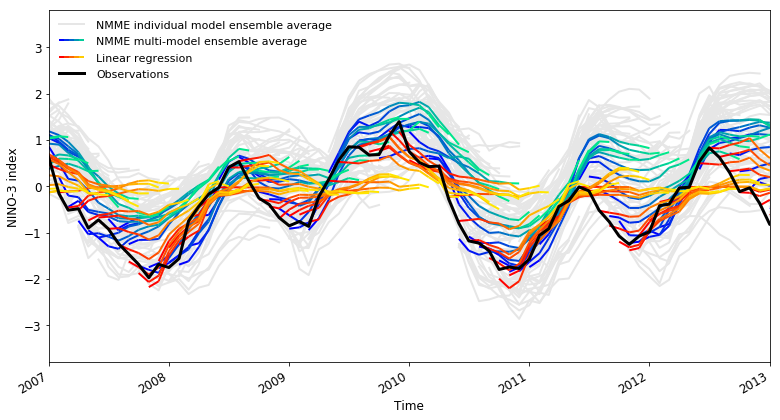

In [99]:
linewidth = 2
fontsize = 12
grey = [0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
figure = plt.figure(figsize=(11,6))
fcst_dates = pd.date_range(start='2006-01', end='2013-01', freq='MS')[::-1]
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(mmm_nino3[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(mmm_nino3[c_gp].sel(init_date=date)), cmap='winter', 
                  **{'linewidth':linewidth,'label':'NMME multi-model ensemble average'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(mmm_nino3[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(mmm_nino3[c_gp].sel(init_date=date)), cmap='winter', 
                  **{'linewidth':linewidth,'label':'_nolegend_'})
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(regr_nino3[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(regr_nino3[c_gp].sel(init_date=date)), cmap='autumn', 
                  **{'linewidth':linewidth,'label':'Linear regression'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(regr_nino3[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(regr_nino3[c_gp].sel(init_date=date)), cmap='autumn', 
                  **{'linewidth':linewidth,'label':'_nolegend_'})

for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cola_nino3[c_gp].sel(init_date=date)).mean('ensemble'),
                 color=grey, zorder=1, label='NMME individual model ensemble average', linewidth=linewidth)
    else:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cola_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(aer04_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(aer04_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florA_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(florA_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florB_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(florB_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm3_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cm3_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_nino3[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cm4_nino3[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)

# for idx, date in enumerate(fcst_dates):
#     plt.plot(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time.values,
#              doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)), color=(0.95,0.95,0.95), zorder=0, label='_nolegend_')

obs_2_use[c_gp].sel(lead_time=0).plot(color='k', linestyle='-', linewidth=linewidth+1, label='Observations')

plt.xlim('2007','2013')
plt.ylim(-3.8,3.8);
plt.xlabel('Time');
plt.ylabel('NINO-3 index');
plt.title('')

# Make the legend -----
span = pd.date_range('2007-02-01','2007-05-01', freq='15D')
plt.plot(span, 3.5*np.ones_like(span.astype(int)), color=grey, zorder=1, linewidth=linewidth)
plt.text('2007-05-25', 3.4, 'NMME individual model ensemble average', fontsize=fontsize-1)
plot_fcst(span, 3.15*np.ones_like(span.astype(int)), cmap='winter', **{'linewidth':linewidth})
plt.text('2007-05-25', 3.05, 'NMME multi-model ensemble average', fontsize=fontsize-1)
plot_fcst(span, 2.8*np.ones_like(span.astype(int)), cmap='autumn', **{'linewidth':linewidth})
plt.text('2007-05-25', 2.7, 'Linear regression', fontsize=fontsize-1)
plt.plot(span, 2.45*np.ones_like(span.astype(int)), color='k', linestyle='-', linewidth=linewidth+1)
plt.text('2007-05-25', 2.35, 'Observations', fontsize=fontsize-1)

plt.tight_layout();

# Let's get an appreciation of the absolute NMME skill by looking at the Gerrity (categorical) skill score and the mean squared skill score (MSSS)

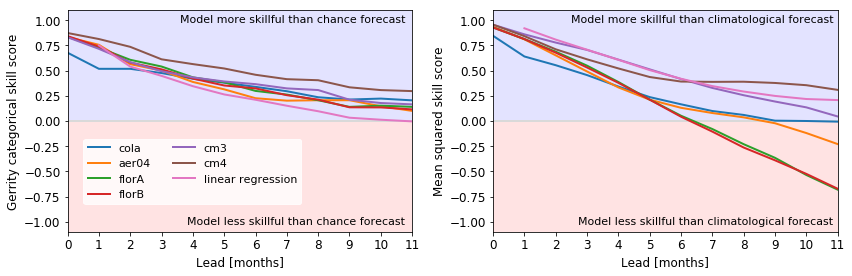

In [100]:
linewidth = 2
fontsize = 12

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=2)

# Pierce's score =============================================================
ref = where_elnino.where(where_elnino==0, other=1) - where_lanina.where(where_lanina==0, other=1)
models = [where_elnino_cola.where(where_elnino_cola==0, other=1) - where_lanina_cola.where(where_lanina_cola==0, other=1), 
          where_elnino_aer04.where(where_elnino_aer04==0, other=1) - where_lanina_aer04.where(where_lanina_aer04==0, other=1), 
          where_elnino_florA.where(where_elnino_florA==0, other=1) - where_lanina_florA.where(where_lanina_florA==0, other=1), 
          where_elnino_florB.where(where_elnino_florB==0, other=1) - where_lanina_florB.where(where_lanina_florB==0, other=1), 
          where_elnino_cm3.where(where_elnino_cm3==0, other=1) - where_lanina_cm3.where(where_lanina_cm3==0, other=1), 
          where_elnino_cm4.where(where_elnino_cm4==0, other=1) - where_lanina_cm4.where(where_lanina_cm4==0, other=1), 
          where_elnino_regr.where(where_elnino_regr==0, other=1) - where_lanina_regr.where(where_lanina_regr==0, other=1)]
model_name = ['cola','aer04','florA','florB','cm3','cm4','linear regression']
edges = [-np.inf, -0.5, 0.5, np.inf]

for idx, model in enumerate(models):
    ax0 = axes[0]     
    obs = ref[c_gp].sel(init_date=slice('1999','2015'))
    fcst = model[c_gp].sel(init_date=slice('1999','2015'))
    contingency = doppyo.skill.contingency(fcst, obs, edges, edges, over_dims='init_date')
    ax0.plot([-1,12],[0,0],'-',color=[0.85,0.85,0.85], zorder=0)
    doppyo.skill.Gerrity_score(contingency).plot(ax=ax0, label=model_name[idx], linewidth=linewidth, color=colors[idx])
    legend = ax0.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.03,0.1,1,1])
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    ax0.set_xlim(0,11)
    ax0.set_xticks(np.arange(0,12))
    ax0.set_ylim(-1.1,1.1)
    ax0.set_ylabel("Gerrity categorical skill score")
    ax0.set_xlabel('Lead [months]')
    
# Shade regions ------
ymin, ymax = ax0.get_ylim()
xmin, xmax = ax0.get_xlim()
ax0.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax0.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)
ax0.text(3.6,0.98,'Model more skillful than chance forecast', fontsize=fontsize-1)
ax0.text(3.8,-1.03,'Model less skillful than chance forecast', fontsize=fontsize-1)

# MSSS ======================================================================
models = [cola_nino3.mean('ensemble'), aer04_nino3.mean('ensemble'), florA_nino3.mean('ensemble'), 
          florB_nino3.mean('ensemble'), cm3_nino3.mean('ensemble'), cm4_nino3.mean('ensemble'), regr_nino3]

# Climatological forecast -----
clim_period = slice('1982','1998')
clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
clim_fcst = (0*obs_2_use['full']).groupby('init_date').apply(lambda_anomalize, clim=-clim)
    
for idx, model in enumerate(models):
    ax1 = axes[1]
    MSE_f = doppyo.skill.mean_squared_error(model[c_gp], obs_2_use[c_gp], over_dims='init_date')
    MSE_o = doppyo.skill.mean_squared_error(clim_fcst, obs_2_use['full'], over_dims='init_date')
    ax1.plot([-1,12],[0,0],'-',color=[0.85,0.85,0.85], zorder=0)
    (1 - MSE_f / MSE_o).plot(ax=ax1, linewidth=linewidth, color=colors[idx])
    ax1.set_xlim(0,11)
    ax1.set_xticks(np.arange(0,12))
    ax1.set_ylim(-1.1,1.1)
    ax1.set_ylabel('Mean squared skill score')
    ax1.set_xlabel('Lead [months]')
    
# Shade regions ------
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
ax1.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax1.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)
ax1.text(2.5,0.98,'Model more skillful than climatological forecast', fontsize=fontsize-1)
ax1.text(2.7,-1.03,'Model less skillful than climatological forecast', fontsize=fontsize-1)
    
fig.tight_layout()

# What is the (sign test) skill relative to linear regression for each of the different anomaly types?

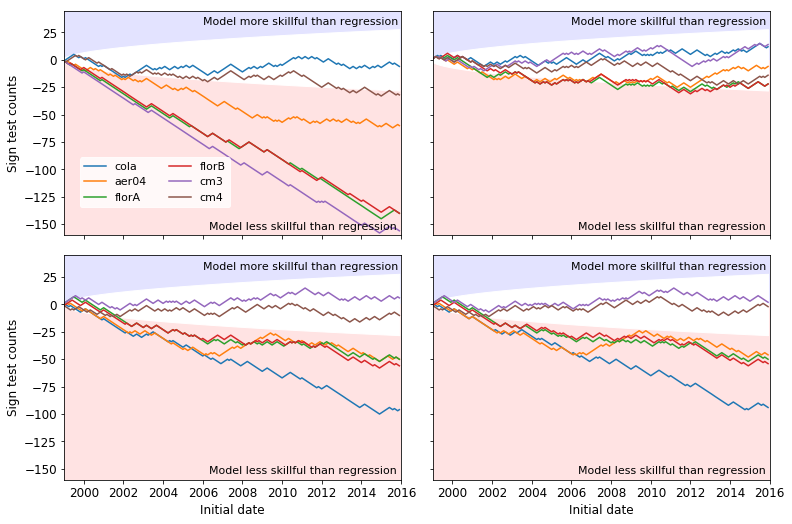

In [101]:
# linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(0.93*2*6,0.93*2*4))
axes = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

lead = 3
anoms = ['c0','c1','c2','c3']
models = [cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

for idx, anom in enumerate(anoms):
    ax = axes.flatten()[idx]
    
    for idz, model in enumerate(models):
        sign, conf = doppyo.skill.sign_test(regr_nino3[anom], 
                                            model[anom].mean('ensemble'), 
                                            obs_2_use[anom].sel(init_date=slice('1999','2015')))

        if idz == 0:
            ax.fill_between(conf.init_date.values,
                            -1 * conf.sel(lead_time=lead), 
                            conf.sel(lead_time=lead), color=grey, label='_nolegend_')
        ax.plot(sign.init_date, -sign.sel(lead_time=lead), label=model_name[idz], color=colors[idz])

    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.03,0.1,1,1])
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
    ax.set_ylim(-160, 45)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Sign test counts')
    if (idx == 2) | (idx == 3):
        ax.set_xlabel('Initial date')
    ax.set_xlim('1999','2016')
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text('2006-01',32,'Model more skillful than regression', fontsize=fontsize-1)
    ax.text('2006-05',-155,'Model less skillful than regression', fontsize=fontsize-1)

fig.tight_layout()

### Plot the area under the curves as a function of lead time
Note that when computing the areas, it is important to only include points where the sign_test had the opportunity to change - ie. when supplying masks to the sign_test, the ssame amsks put also be applied before the integral is calculated

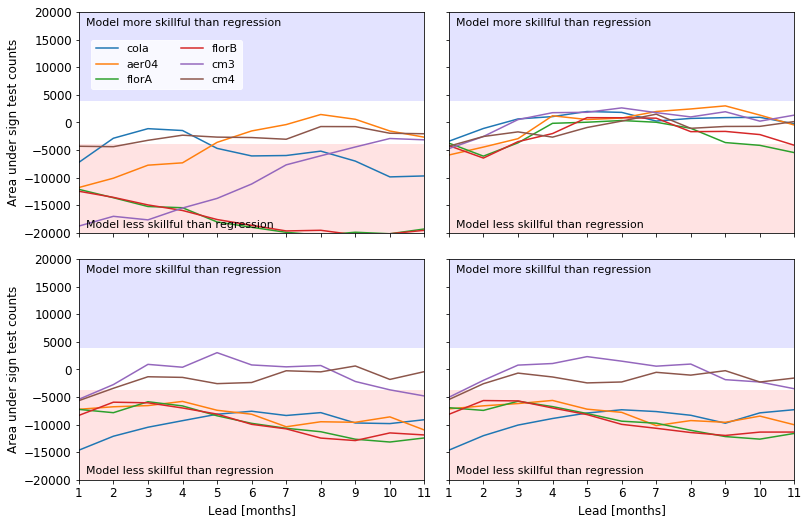

In [102]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(0.95*2*6,0.93*2*4))
axes = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

anoms = ['c0','c1','c2','c3']
models = [cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3]
model_name = ['cola','aer04','florA','florB','cm3','cm4']


for idx, anom in enumerate(anoms):
    ax = axes.flatten()[idx]
    
    for idz, model in enumerate(models):
        sign_test = doppyo.skill.sign_test(regr_nino3[anom], 
                                           model[anom].mean('ensemble'), 
                                           obs_2_use[anom].sel(init_date=slice('1999','2015')))
        sign_masked = sign_test[0]
        conf_masked = sign_test[1]
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect')
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect')

        if idz == 0:
            ax.fill_between(conf_area.lead_time, -1 * conf_area, conf_area, 
                            facecolor=grey, linewidth=0.0)
            
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], color=colors[idz])
    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper left', bbox_to_anchor=[0.02,0,1,0.9])
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')

    # Adjust y-axes limits to be symmetric -----
    ymin, ymax = ax.get_ylim()
    ylim = max([abs(ymin), abs(ymax)])
    ax.set_ylim(-20000, 20000)
    ax.set_xticks(np.arange(0,12))
    ax.set_xlim(1,11)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Area under sign test counts')
    if (idx == 2) | (idx == 3):
        ax.set_xlabel('Lead [months]')
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text(1.2,17500,'Model more skillful than regression', fontsize=fontsize-1)
    ax.text(1.2,-19000,'Model less skillful than regression', fontsize=fontsize-1)

fig.tight_layout()

# How do the model **c1**, **c2** and **c1ncv** anomalies compare when assessed relative to observed **c2** anomalies?

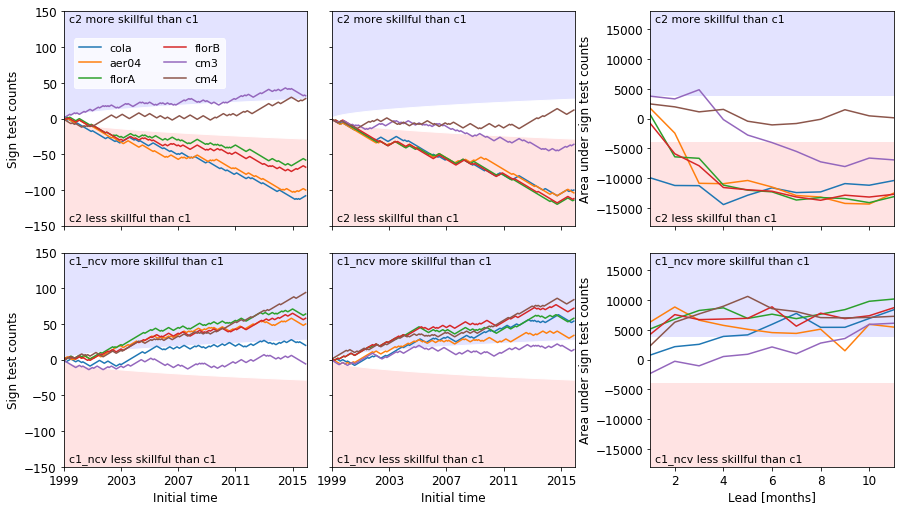

In [103]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(0.97*2*6,0.93*2*4))
axes_locs = [[0,0.5,0.29,0.4],[0.32,0.5,0.29,0.4],[0.70,0.5,0.29,0.4],
             [0,0.05,0.29,0.4],  [0.32,0.05,0.29,0.4],  [0.70,0.05,0.29,0.4]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
anoms = [('c1',c_gp),('c1','c1ncv')]
models = [cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count=0
for idx, anom in enumerate(anoms):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')))

            if idy == 0:
                ax.fill_between(conf.init_date.values,
                                -1 * conf.sel(lead_time=lead), 
                                conf.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot(sign.init_date, -sign.sel(lead_time=lead), label=model_name[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Sign test counts')

            ax.set_ylim(-150,150)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if (idy == 0) & (idx == 0):
                ax.text('1999-05',135,'c2 more skillful than c1', fontsize=fontsize-1)
                ax.text('1999-05',-144,'c2 less skillful than c1', fontsize=fontsize-1)
            elif (idy == 0) & (idx == 1):
                ax.text('1999-05',135,'c1_ncv more skillful than c1', fontsize=fontsize-1)
                ax.text('1999-05',-142,'c1_ncv less skillful than c1', fontsize=fontsize-1)

            if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper left', bbox_to_anchor=[0.02,0,1,0.9])
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                           model[anom[1]].mean('ensemble'), 
                                           obs_2_use[c_gp].sel(init_date=slice('1999','2015')))

        sign_masked = sign_test[0].fillna(0)
        conf_masked = sign_test[1].fillna(0)
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect')
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect')

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        
        if (idy == 0) & (idx == 0):
            ax.text(1.2,16200,'c2 more skillful than c1', fontsize=fontsize-1)
            ax.text(1.2,-17200,'c2 less skillful than c1', fontsize=fontsize-1)
        elif (idy == 0) & (idx == 1):
            ax.text(1.2,16200,'c1_ncv more skillful than c1', fontsize=fontsize-1)
            ax.text(1.2,-17100,'c1_ncv less skillful than c1', fontsize=fontsize-1)

        ax.set_ylim(-18000,18000)
        ax.set_ylabel('Area under sign test counts')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')

    count += 1

# fig.tight_layout()

# What about **onset** of El Nino and La Nina?

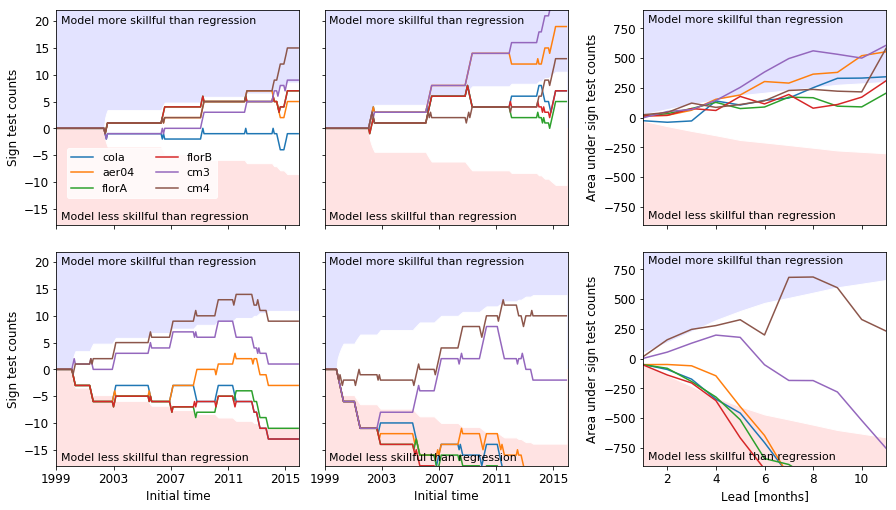

In [104]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(0.97*2*6,0.93*2*4))
axes_locs = [[0,0.5,0.29,0.4],[0.32,0.5,0.29,0.4],[0.70,0.5,0.29,0.4],
             [0,0.05,0.29,0.4],  [0.32,0.05,0.29,0.4],  [0.70,0.05,0.29,0.4]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_onset,
         where_lanina_onset]
models = [cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count = 0
for idx, mask in enumerate(masks):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(regr_nino3[c_gp].where(mask[c_gp]), 
                                                model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

            if idy == 0:
                ax.fill_between(conf.init_date.values,
                                -1 * conf.sel(lead_time=lead), 
                                conf.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot(sign.init_date, -sign.sel(lead_time=lead), label=model_name[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Sign test counts')

            ax.set_ylim(-18,22)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text('1999-05',19.5,'Model more skillful than regression', fontsize=fontsize-1)
                ax.text('1999-05',-17,'Model less skillful than regression', fontsize=fontsize-1)

            if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.02,0.1,1,1])
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(regr_nino3[c_gp].where(mask[c_gp]), 
                                           model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                           obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

        sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
        conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect')
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect')

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        if idy == 0:
            ax.text(1.2,800,'Model more skillful than regression', fontsize=fontsize-1)
            ax.text(1.2,-850,'Model less skillful than regression', fontsize=fontsize-1)

        ax.set_ylim(-900,900)
        ax.set_ylabel('Area under sign test counts')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')

    count += 1

# fig.tight_layout()

# What about **decay** of El Nino and La Nina?

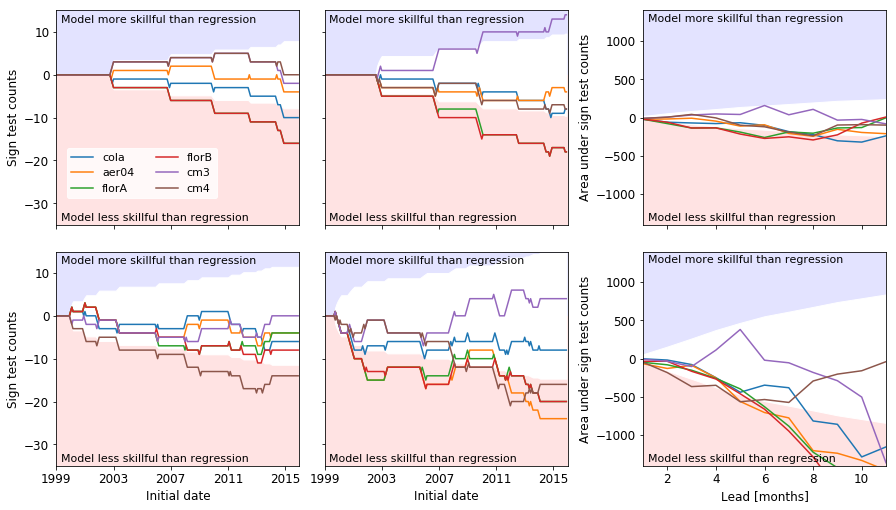

In [105]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(0.97*2*6,0.93*2*4))
axes_locs = [[0,0.5,0.29,0.4],[0.32,0.5,0.29,0.4],[0.70,0.5,0.29,0.4],
             [0,0.05,0.29,0.4],  [0.32,0.05,0.29,0.4],  [0.70,0.05,0.29,0.4]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_decay,
         where_lanina_decay]
models = [cola_nino3, aer04_nino3, florA_nino3, florB_nino3, cm3_nino3, cm4_nino3]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count = 0
for idx, mask in enumerate(masks):
        for idy, model in enumerate(models):
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(regr_nino3[c_gp].where(mask[c_gp]), 
                                                    model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                                    obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

                if idy == 0:
                    ax.fill_between(conf.init_date.values,
                                    -1 * conf.sel(lead_time=lead), 
                                    conf.sel(lead_time=lead), color=grey, label='_nolegend_')
                ax.plot(sign.init_date, -sign.sel(lead_time=lead), label=model_name[idy])
                
                ax.set_xlim('1999','2016')
                ax.set_xticks(['1999','2003','2007','2011','2015'])
                if axI < len(leads) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial date')
                if idz == 0:
                    ax.set_ylabel('Sign test counts')
                  
                ax.set_ylim(-35,15)
                if idz > 0:
                    ax.set_yticklabels([])
                    
                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if idy == 0:
                    ax.text('1999-05',12.2,'Model more skillful than regression', fontsize=fontsize-1)
                    ax.text('1999-05',-34,'Model less skillful than regression', fontsize=fontsize-1)
                    
                if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                    legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.02,0.1,1,1])
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]
            sign_test = doppyo.skill.sign_test(regr_nino3[c_gp].where(mask[c_gp]), 
                                               model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                               obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))
            
            sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
            conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
            sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                               x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect')
            conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                               x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect')
            
            if idy == 0:
                ax.fill_between(conf_area.lead_time,
                                -1 * conf_area, conf_area, color=grey, label='_nolegend_')
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz])
            
            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text(1.2,1250,'Model more skillful than regression', fontsize=fontsize-1)
                ax.text(1.2,-1350,'Model less skillful than regression', fontsize=fontsize-1)
            
            ax.set_ylim(-1400,1400)
            ax.set_ylabel('Area under sign test counts')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')

        count += 1

# fig.tight_layout()